In [3]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image

In [4]:
samples = 20000
df = pd.read_csv("train.csv")
df = df.loc[:samples,:]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)

In [5]:
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)

Size of training data: (20001, 2)
Number of unique classes: 1020


In [6]:
data = pd.DataFrame(df['landmark_id'].value_counts())
#index the data frame
data.reset_index(inplace=True) 
data.columns=['landmark_id','count']

print(data.head(10))
print(data.tail(10))

   landmark_id  count
0         1924    944
1           27    504
2          454    254
3         1346    244
4         1127    201
5          870    193
6         2185    177
7         1101    162
8          389    140
9          219    139
      landmark_id  count
1010         1404      2
1011         1403      2
1012          585      2
1013          604      2
1014          611      2
1015          625      2
1016         1250      2
1017         2239      2
1018          655      2
1019         1064      2


count    1020.000000
mean       19.608824
std        41.653684
min         2.000000
25%         5.000000
50%         9.000000
75%        21.000000
max       944.000000
Name: count, dtype: float64


Text(0, 0.5, 'Occurences')

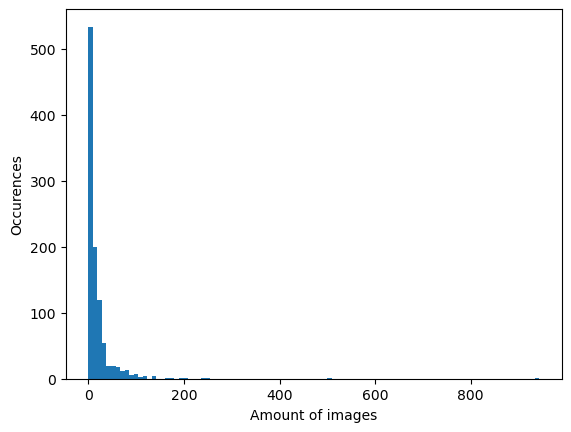

In [10]:
print(data['count'].describe())#statistical data for the distribution
plt.hist(data['count'],100,range = (0,944),label = 'test')#Histogram of the distribution
plt.xlabel("Amount of images")
plt.ylabel("Occurences")

Amount of classes with five and less datapoints: 322
Amount of classes with with between five and 10 datapoints: 342


Text(0, 0.5, 'Number of images')

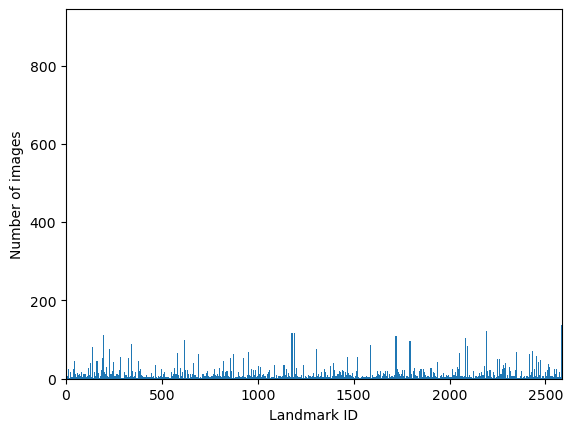

In [11]:
print("Amount of classes with five and less datapoints:", (data['count'].between(0,5)).sum()) 

print("Amount of classes with with between five and 10 datapoints:", (data['count'].between(5,10)).sum())

n = plt.hist(df["landmark_id"],bins=df["landmark_id"].unique())
freq_info = n[0]

plt.xlim(0,data['landmark_id'].max())
plt.ylim(0,data['count'].max())
plt.xlabel('Landmark ID')
plt.ylabel('Number of images')

In [48]:


base_path = "./images/"


In [43]:
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])

LabelEncoder()

In [44]:
df.head()


,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [45]:
def encode_label(lbl):
    return lencoder.transform(lbl)

In [46]:
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)

In [66]:
def get_image_from_number(num, dataframe):
    fname, label = dataframe.iloc[num]

    fname = fname + ".jpg"

    f1, f2, f3 = fname[0], fname[1], fname[2]
    path = os.path.join(base_path, f1, f2, f3, fname)

    im = cv2.imread(path)

    if im is None:          # ✅ ADD THIS
        return None, None  # ✅ ADD THIS

    return im, label


4 sample images from random classes:


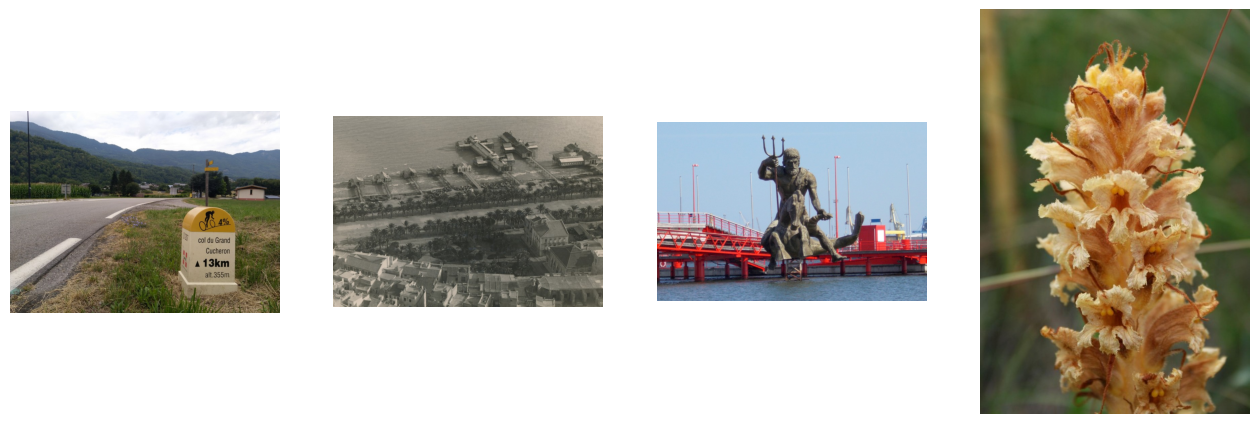

In [67]:
print("4 sample images from random classes:")
fig=plt.figure(figsize=(16, 16))
for i in range(1,5):
    a = random.choices(os.listdir(base_path), k=3)
    folder = base_path+'/'+a[0]+'/'+a[1]+'/'+a[2]
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1, 4, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [68]:
from keras.applications import VGG19
from keras.layers import *
from keras import Sequential


In [69]:
### Parameters
# learning_rate   = 0.0001
# decay_speed     = 1e-6
# momentum        = 0.09

# loss_function   = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
#new_layer = Dense(num_classes, activation=activations.softmax, name='prediction')
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)

In [71]:
model = Sequential()
for layer in source_model.layers[:-1]: # go through until last layer
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
#     if layer == source_model.layers[-3]:
#         model.add(drop_layer)
# model.add(drop_layer2)
model.add(Dense(num_classes, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Bat  (None, 224, 224, 3)       12        
 chNormalization)                                                
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                      

In [72]:
opt1 = keras.optimizers.RMSprop(learning_rate = 0.0001, momentum = 0.09)
opt2 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=opt1,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

#sgd = SGD(lr=learning_rate, decay=decay_speed, momentum=momentum, nesterov=True)
# rms = keras.optimizers.RMSprop(lr=learning_rate, momentum=momentum)
# model.compile(optimizer=rms,
#               loss=loss_function,
#               metrics=["accuracy"])
# print("Model compiled! \n")

In [73]:
### Function used for processing the data, fitted into a data generator.
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)
    


In [74]:
def get_batch(dataframe,start, batch_size):
    image_array = []
    label_array = []
    
    end_img = start+batch_size
    if end_img > len(dataframe):
        end_img = len(dataframe)

    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)
        if im is None:      
            continue        
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(int(label))

        
    label_array = encode_label(label_array)
    if len(image_array) == 0:   # ✅ ADD THIS
        return None, None       # ✅ ADD THIS
    return np.array(image_array), np.array(label_array)


In [75]:
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 15

# Split train data up into 80% and 20% validation
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))])
print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")

    


Training on: 16000 samples
Validation on: 4001 samples


In [76]:
for e in range(epochs):
    print("Epoch: ", str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):

        X_train, y_train = get_batch(train, it*batch_size, batch_size)
        if X_train is None:    
            continue           
        model.train_on_batch(X_train, y_train)
    model.save("Model.h5")

Epoch:  1/15




C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  2/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  3/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  4/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  5/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  6/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  7/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  8/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  9/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  10/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  11/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  12/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  13/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  14/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  15/15


C:\Users\vijva\anaconda3\envs\landmark\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [80]:
batch_size = 16

errors = 0
good_preds = []
bad_preds = []

for it in range(int(np.ceil(len(validate)/batch_size))):

    X_train, y_train = get_batch(validate, it*batch_size, batch_size)
    if X_train is None:        # ✅ ADD THIS
        continue              # ✅ ADD THIS
    result = model.predict(X_train)

    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        print("Class:", cla[idx], "- Confidence:", np.round(res[cla[idx]],2), "- GT:", y_train[idx])
        if idx >= len(y_train):
            break

        if cla[idx] != y_train[idx]:
            errors = errors + 1
            bad_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])

print("Errors: ", errors, "Acc:", np.round(100*(len(validate)-errors)/len(validate),2))



1/1 [==============================] - 2s 2s/step
Class: 750 - Confidence: 0.15 - GT: 145
1/1 [==============================] - 0s 415ms/step
Class: 750 - Confidence: 0.12 - GT: 867
1/1 [==============================] - 0s 466ms/step
Class: 750 - Confidence: 0.11 - GT: 673
1/1 [==============================] - 0s 460ms/step
Class: 750 - Confidence: 0.24 - GT: 538
1/1 [==============================] - 0s 445ms/step
Class: 750 - Confidence: 0.09 - GT: 338
1/1 [==============================] - 0s 415ms/step
Class: 750 - Confidence: 0.08 - GT: 1018
Errors:  6 Acc: 99.85


In [81]:
#Good predictions
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[2], reverse=True))

In [82]:
len(good_preds)

0

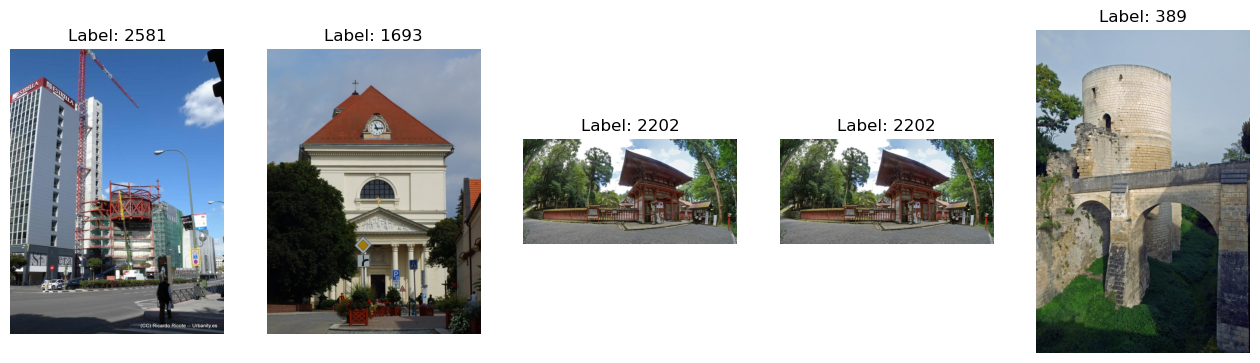

In [95]:
import random

shown = 0
fig = plt.figure(figsize=(16,16))

while shown < 5:
    n = random.randint(0, len(validate)-1)
    img, lbl = get_image_from_number(n, validate)
    if img is None:
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1,5,shown+1)
    plt.imshow(img)
    plt.title("Label: " + str(lbl))
    plt.axis("off")

    shown += 1

plt.show()


In [92]:
for i, item in enumerate(bad_preds):
    n = int(item[0])
    img, lbl = get_image_from_number(n, validate)
    print(i, "Index:", n, "Image exists:", img is not None)


0 Index: 16 Image exists: True
1 Index: 32 Image exists: False
2 Index: 1072 Image exists: False
3 Index: 1584 Image exists: False
4 Index: 1744 Image exists: False
5 Index: 3616 Image exists: False


In [90]:
print("Length of bad_preds:", len(bad_preds))


Length of bad_preds: 6


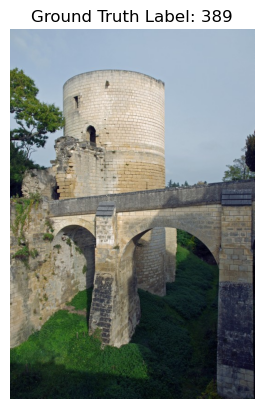

In [99]:
# check output
import cv2
import matplotlib.pyplot as plt

found = False

for n in range(len(validate)):
    img, lbl = get_image_from_number(n, validate)
    
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title("Ground Truth Label: " + str(lbl))
        plt.axis("off")
        plt.show()
        found = True
        break

if not found:
    print("No image files found in validation set")
